# Social network exploration

This notebook starts from the output generated at step 4 (04_trades_featureEng.ipynb), building and exploring the network of buyers and sellers.

In [33]:
import numpy as np
import pandas as pd 
from network_analysis_exp import *
from network_bond_graph import *
from network_modelling import *
from network_visualization import *
import networkx as nx
import seaborn as sns

from datetime import timedelta

from bokeh.io import show, output_notebook
from matplotlib import pyplot as plt

output_notebook()

Loading BokehJS ...

## Importing data

In [3]:
datafolder = ".."+"/data/"
filename = "02_instrumentsdf_2.pkl"

df = pd.read_pickle(datafolder+filename)

In [4]:
edge_attr = ['currency', 'invoice_date', 'invoice_amount',
        'is_due', 'due_date',
        'value_date', 'has_purchase']

In [63]:
g = nx.from_pandas_edgelist(df,
                            source='debtor_name_1',
                            target='customer_name_1',
                            edge_attr=edge_attr,
                            create_using=nx.MultiDiGraph)

In [6]:
 g_flat = nx.from_pandas_edgelist(df,
                                 source='debtor_name_1',
                                 target='customer_name_1',
                                 create_using=nx.DiGraph)

In [7]:
sorted_components = sorted([(len(component),component) for component in nx.connected_components(g_flat.to_undirected())], key=lambda x: x[0], reverse=True)

In [8]:
giant_component = g.subgraph(nodes=sorted_components[0][1])

In [10]:
giant_component_flat = g_flat.subgraph(nodes=sorted_components[0][1])

In [11]:
df = df[df.debtor_name_1.isin(list(giant_component.nodes)) | df.customer_name_1.isin(list(giant_component.nodes))]

In [13]:
pastdue_col = 'is_pastdue90'
past_due_nodes = df[df[pastdue_col]==True]['debtor_name_1'].unique()

In [14]:
df.head()

,customer_id,customer_name_1,debtor_id,debtor_name_1,invoice_number,invoice_date,due_date,invoice_amount,purchase_amount,purchase_amount_open,...,total_repayment,total_impairment,is_open,we_payment_share,has_purchase,has_deduction,is_due,has_discharge,cash_check,unexpl
uid,,,,,,,,,,,,,,,,,,,,,
2744:79/231,2004008,Castillo GmbH,79,Sana Hyannis Sarl,2744,2013-07-23,2013-08-02,913.70,0.0,0.0,...,0.00,0.00,False,NaN,False,False,True,True,913.70,True
2861:79/232,2004008,Castillo GmbH,79,Sana Hyannis Sarl,2861,2013-07-30,2013-08-09,2233.45,0.0,0.0,...,0.00,0.00,False,NaN,False,False,True,True,2233.45,True
2932:79/233,2004008,Castillo GmbH,79,Sana Hyannis Sarl,2932,2013-08-06,2013-08-16,1370.50,0.0,0.0,...,1370.50,0.00,False,1.0,False,False,True,False,0.00,False
1472:489/688,2004009,Orpheus Wyandotte Supply LLC,489,Isfahan SA,1472,2013-08-13,2013-08-23,9195.10,0.0,0.0,...,0.00,0.00,False,NaN,False,False,True,True,9195.10,True
2042:512/645,2004009,Orpheus Wyandotte Supply LLC,512,Aldrich Chloe GmbH,2042,2013-08-13,2013-08-23,4594.60,0.0,0.0,...,164.35,164.35,False,1.0,False,False,True,True,4265.90,True


In [15]:
 first_invoice_date = df['invoice_date'].min()
last_invoice_date = df['invoice_date'].max()
print('{0} - {1}'.format(first_invoice_date,last_invoice_date))

2013-07-23 00:00:00 - 2018-12-18 00:00:00


In [16]:
 num_days = (last_invoice_date-first_invoice_date).days

In [17]:
days_linspace = reversed(np.linspace(start=num_days, stop=0,num=100,endpoint=False, dtype=int))

In [20]:
dates_linspace = [first_invoice_date + timedelta(days=int(x)) for x in days_linspace]

In [21]:
def get_time_window(row):
    return dates_linspace[np.argmax([row['invoice_date'] <= date for date in dates_linspace])]

In [22]:
df['invoice_date_window'] = df.apply(get_time_window,axis=1)

In [23]:
 debtors = df['debtor_name_1'].unique()

## Network evolution

In [24]:
 num_nodes_window = [nx.from_pandas_edgelist(df[(dates_linspace[date_index] <= df.invoice_date) &
       (df.invoice_date<date)],
                            source='debtor_name_1',
                            target='customer_name_1',
                            edge_attr=edge_attr,
                            create_using=nx.Graph).number_of_nodes() for date_index, date in enumerate(dates_linspace[1:])]

In [25]:
num_debtor_window = [len(df[(dates_linspace[date_index] <= df.invoice_date) &
       (df.invoice_date<date)].debtor_name_1.unique()) for date_index, date in enumerate(dates_linspace[1:])]

In [26]:
num_customer_window = [len(df[(dates_linspace[date_index] <= df.invoice_date) &
       (df.invoice_date<date)].customer_name_1.unique()) for date_index, date in enumerate(dates_linspace[1:])]

In [27]:
cum_num_nodes_window = [nx.from_pandas_edgelist(df[(df.invoice_date<date)],
                            source='debtor_name_1',
                            target='customer_name_1',
                            edge_attr=edge_attr,
                            create_using=nx.Graph).number_of_nodes() for date_index, date in enumerate(dates_linspace[1:])]

In [28]:
cum_num_debtor_window = [len(df[(df.invoice_date<date)].debtor_name_1.unique()) for date_index, date in enumerate(dates_linspace[1:])]

In [29]:
cum_num_customer_window = [len(df[(df.invoice_date<date)].customer_name_1.unique()) for date_index, date in enumerate(dates_linspace[1:])]

In [30]:
num_transations_window = [df[(dates_linspace[date_index] <= df.invoice_date) &
       (df.invoice_date<date)].shape[0] for date_index, date in enumerate(dates_linspace[1:])]

In [31]:
num_pastdue90_transations_window = [df[(dates_linspace[date_index] <= df.invoice_date) &
       (df.invoice_date<date) &
        (df[pastdue_col]==True)].shape[0] for date_index, date in enumerate(dates_linspace[1:])]

C:\Users\DavideMariani\Anaconda3\envs\mlflow\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in true_divide


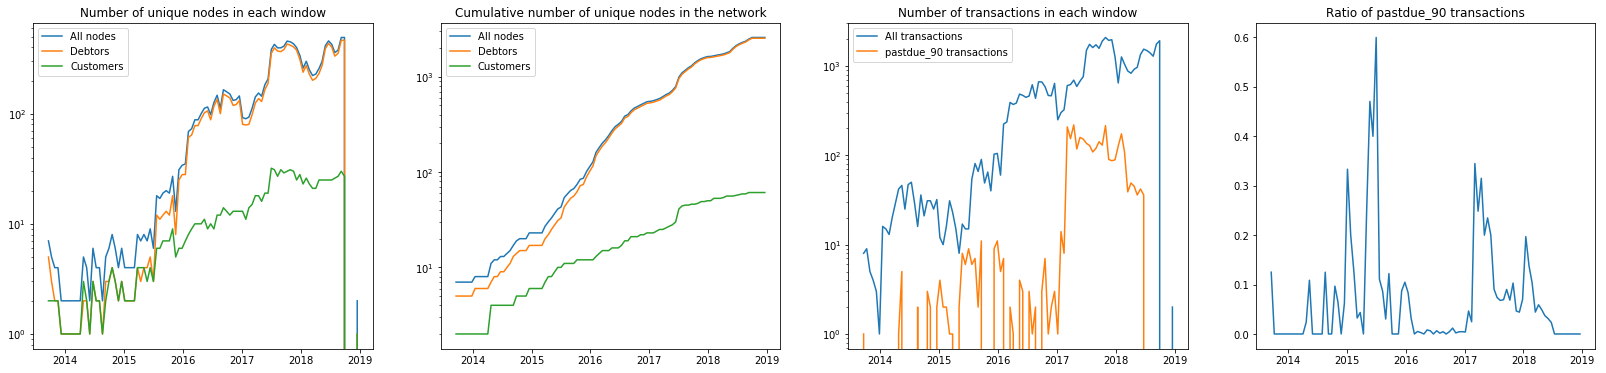

In [34]:
fig,axes = plt.subplots(1, 4, figsize=(28,6))
axes[0].plot(dates_linspace[1:], num_nodes_window, label='All nodes')
axes[0].plot(dates_linspace[1:], num_debtor_window, label='Debtors')
axes[0].plot(dates_linspace[1:], num_customer_window, label='Customers')
axes[0].legend()
axes[0].set_yscale("log", nonposy='clip')
axes[0].set_title('Number of unique nodes in each window')
axes[1].plot(dates_linspace[1:], cum_num_nodes_window, label='All nodes')
axes[1].plot(dates_linspace[1:], cum_num_debtor_window, label='Debtors')
axes[1].plot(dates_linspace[1:], cum_num_customer_window, label='Customers')
axes[1].set_yscale("log", nonposy='clip')
axes[1].legend()
axes[1].set_title('Cumulative number of unique nodes in the network')
axes[2].plot(dates_linspace[1:], num_transations_window, label='All transactions')
axes[2].plot(dates_linspace[1:], num_pastdue90_transations_window, label='pastdue_90 transactions')
axes[2].legend()
axes[2].set_yscale("log", nonposy='clip')
axes[2].set_title('Number of transactions in each window')
axes[3].plot(dates_linspace[1:],np.nan_to_num(np.divide(num_pastdue90_transations_window,num_transations_window)))
axes[3].set_title('Ratio of pastdue_90 transactions')
plt.show()

In [35]:
print('Number of nodes beeing debtor and customer simultanously -',len(np.intersect1d(df.debtor_name_1.unique(),df.customer_name_1.unique())))

Number of nodes beeing debtor and customer simultanously - 14


## Transaction amounts in time

In [36]:
group_invoice_date_window = df.groupby(by=['debtor_name_1','invoice_date_window']).sum()['invoice_amount']

In [37]:
 flow_array = np.empty([len(debtors),len(dates_linspace)])
for debtor_key, debtor in enumerate(debtors):
    for time_window_key, time_window in enumerate(dates_linspace):
        try:
            flow_array[debtor_key, time_window_key] = group_invoice_date_window.loc[debtor].loc[time_window]
        except:
            flow_array[debtor_key, time_window_key] = 0

In [38]:
 row_max = flow_array.max(axis=1)
flow_array = flow_array / row_max[:, np.newaxis]

Text(0.5,1,'All debtors')

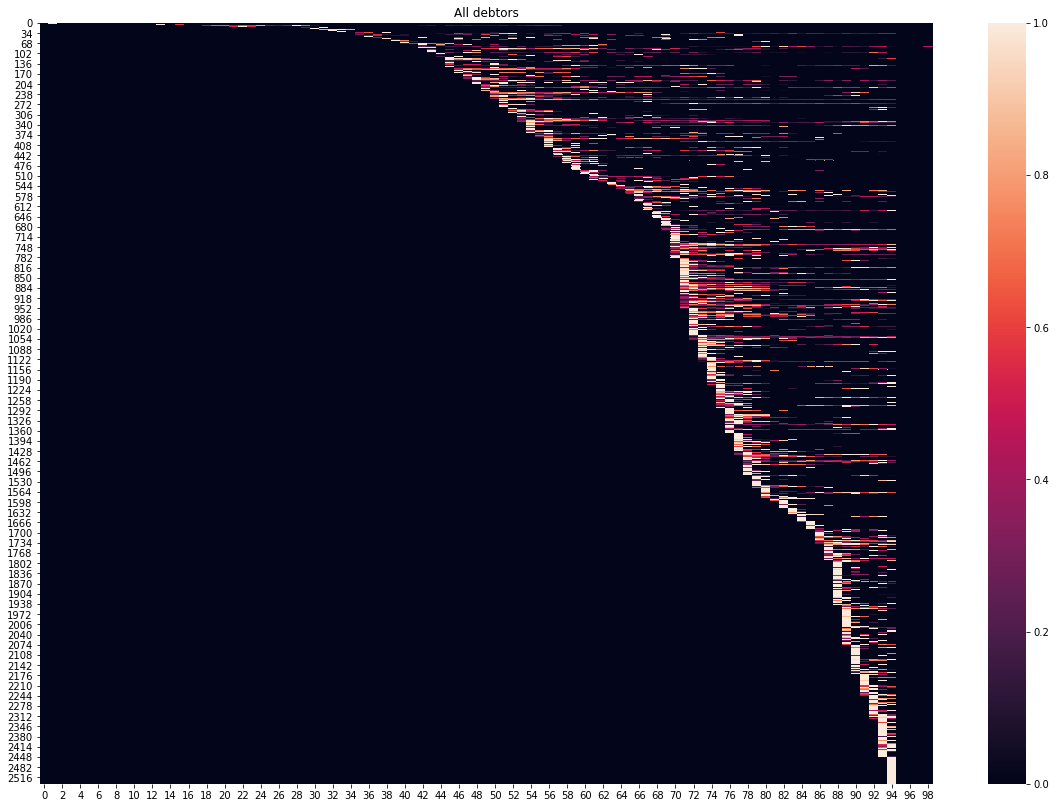

In [39]:
plt.figure(figsize=(20,14))
sns.heatmap(flow_array)
plt.title('All debtors')

In [40]:
print("Debotrs on Y-axis, time-windows on X-axis (approx 2.5 week). Normalised per row. black is no transactions. white - maximum sum-value per debtor")

Debotrs on Y-axis, time-windows on X-axis (approx 2.5 week). Normalised per row. black is no transactions. white - maximum sum-value per debtor


In [41]:
 y = np.bincount(np.where(flow_array!=0)[0])

In [42]:
 y = y-1

In [43]:
 ii = np.nonzero(y)[0]

Text(0.5,1,'Debotrs with more than 1 time-window with transactions')

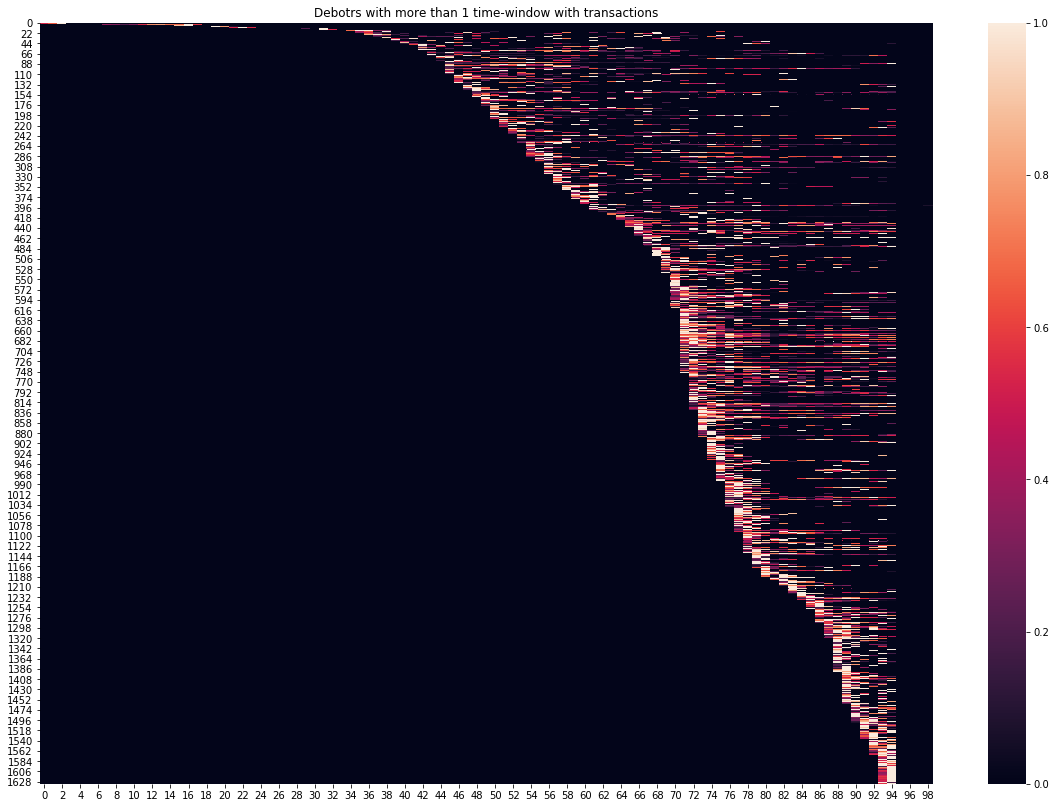

In [44]:
 plt.figure(figsize=(20,14))
sns.heatmap(flow_array[ii,:])
plt.title('Debotrs with more than 1 time-window with transactions')

## Pastdue90 transactions over time

In [46]:
df['invoice_amount_pastdue90'] = df.apply(lambda row: row['invoice_amount'] if row[pastdue_col] else 0, axis=1)

In [47]:
group_invoice_date_window_pastdue_90 = df.groupby(by=['debtor_name_1','invoice_date_window']).sum()['invoice_amount_pastdue90']

In [48]:
flow_array_pastdue_90 = np.empty([len(np.intersect1d(debtors,past_due_nodes)),len(dates_linspace)])
for debtor_key, debtor in enumerate(np.intersect1d(debtors,past_due_nodes)):
    for time_window_key, time_window in enumerate(dates_linspace):
        try:
            flow_array_pastdue_90[debtor_key, time_window_key] = group_invoice_date_window_pastdue_90.loc[debtor].loc[time_window]
        except:
            flow_array_pastdue_90[debtor_key, time_window_key] = 0

In [49]:
row_max = flow_array_pastdue_90.max(axis=1)
row_max[row_max==0]=1
flow_array_pastdue_90 = flow_array_pastdue_90 / row_max[:, np.newaxis]

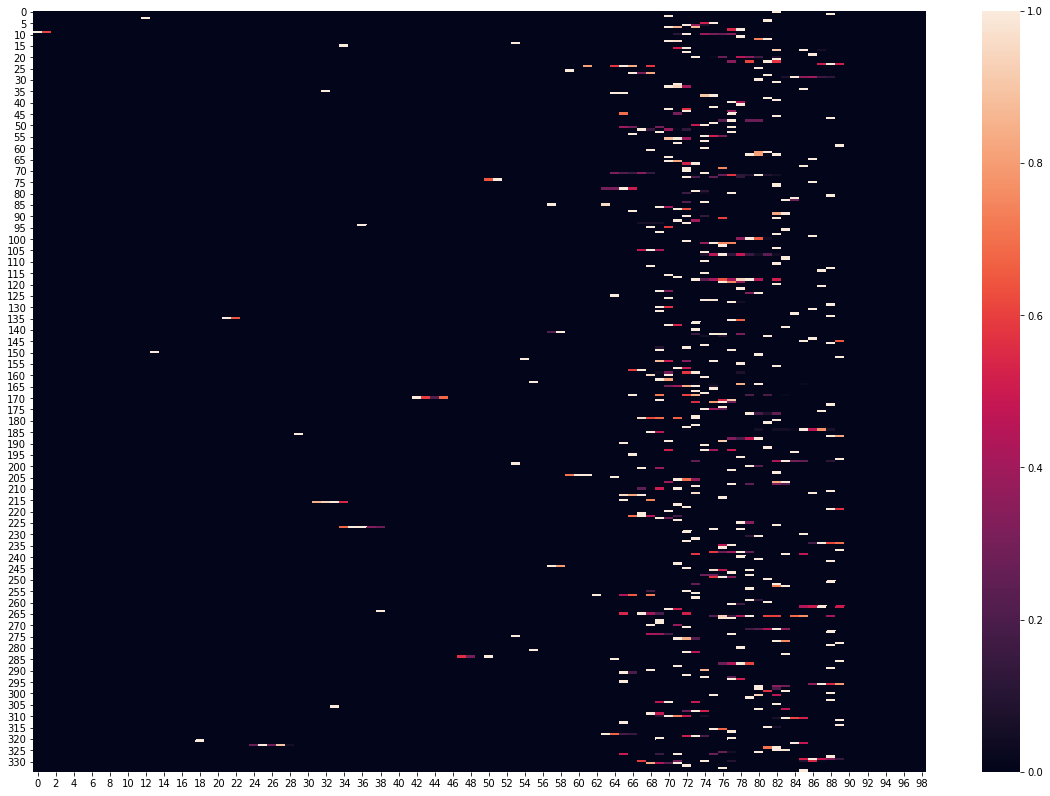

In [50]:
plt.figure(figsize=(20,14))
sns.heatmap(flow_array_pastdue_90)

## Degree in time

In [51]:
 list_degree = []

In [52]:
 for date_index, date in enumerate(dates_linspace[1:]):
    network = nx.from_pandas_edgelist(df[(dates_linspace[date_index] <= df.invoice_date) &
       (df.invoice_date<date)],
                            source='debtor_name_1',
                            target='customer_name_1',
                            edge_attr=edge_attr,
                            create_using=nx.MultiDiGraph)
    for node in giant_component.nodes:
        list_degree.append({'degree':network.out_degree(node) if network.has_node(node) else 0,
                           'date':date})

In [53]:
df_degree = pd.DataFrame.from_records(list_degree)

In [54]:
 df_degree_clean = df_degree[df_degree.date.isin(df.invoice_date_window)]

C:\Users\DavideMariani\Anaconda3\envs\mlflow\lib\site-packages\matplotlib\ticker.py:2198: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  "Data has no positive values, and therefore cannot be "


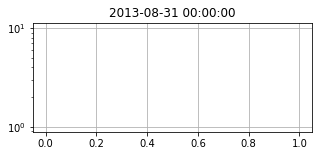

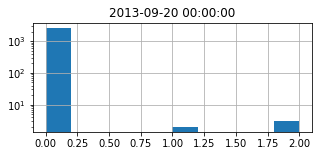

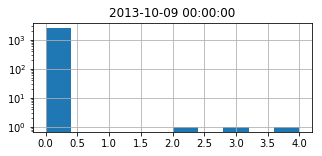

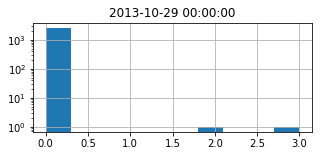

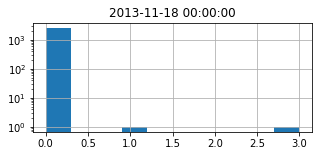

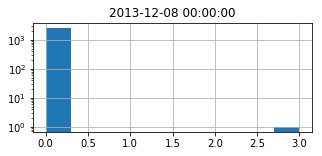

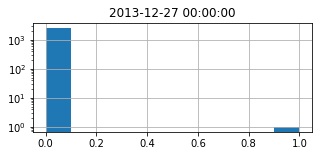

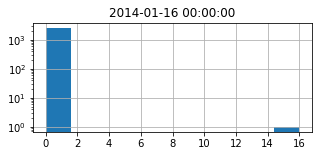

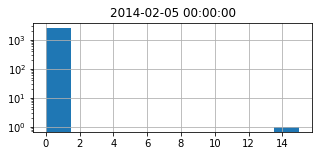

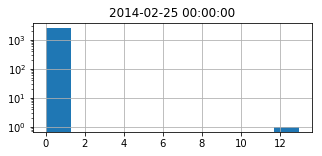

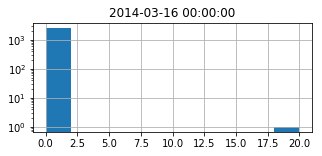

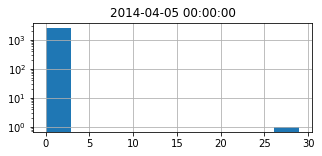

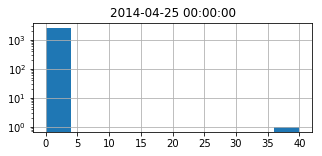

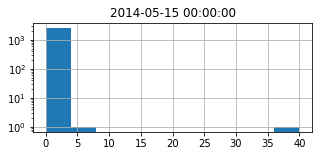

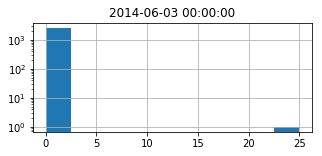

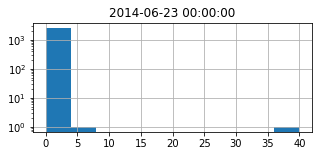

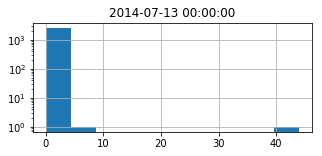

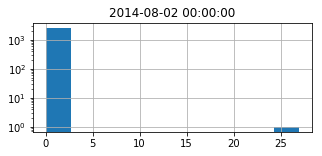

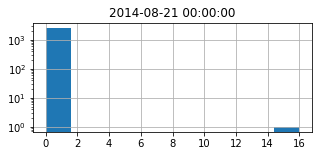

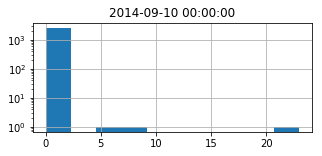

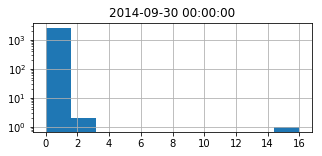

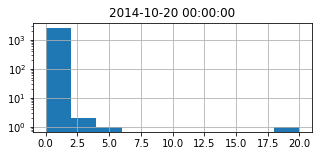

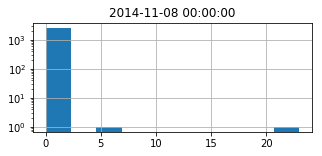

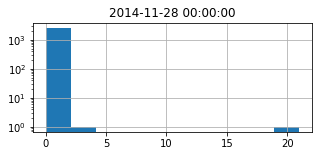

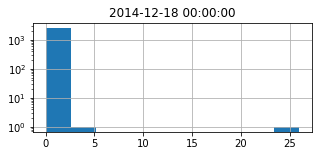

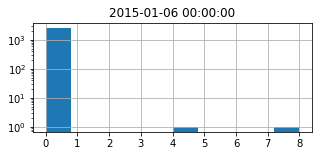

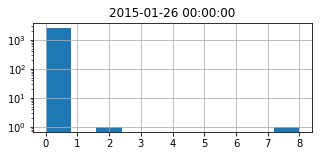

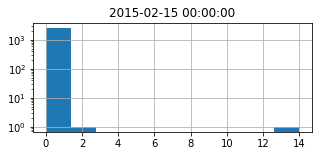

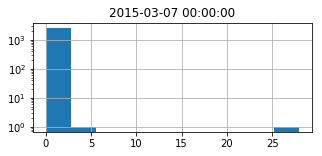

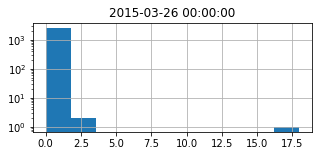

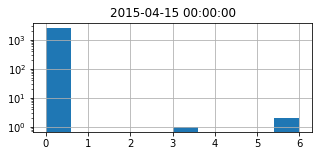

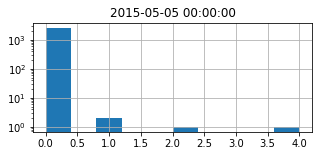

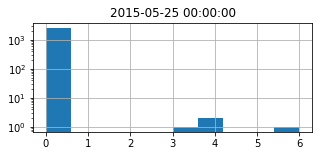

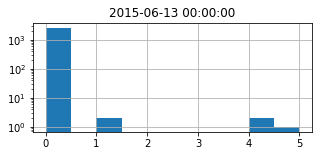

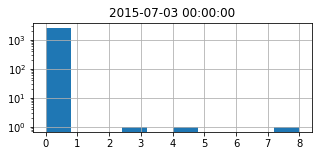

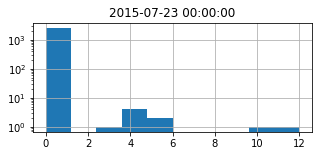

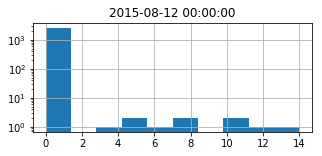

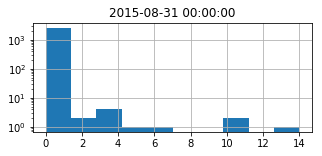

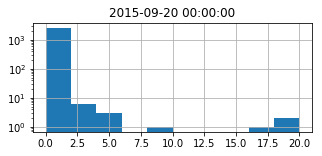

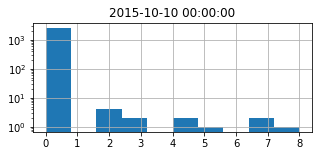

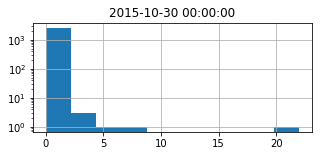

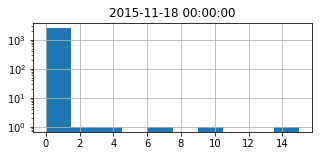

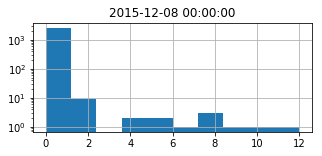

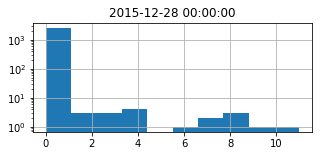

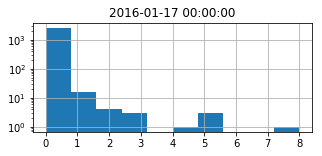

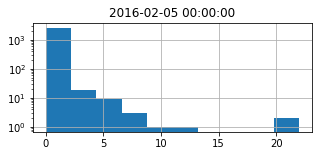

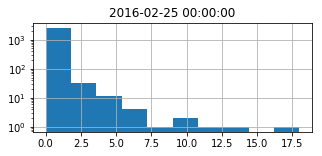

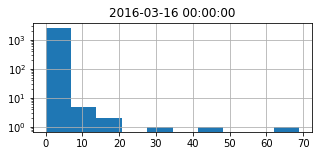

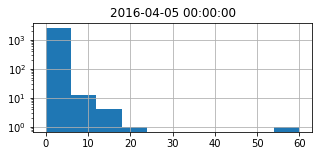

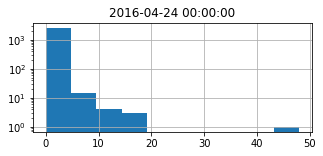

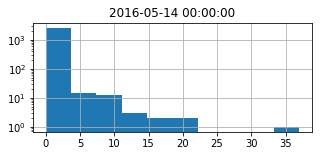

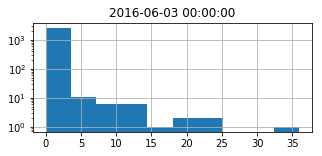

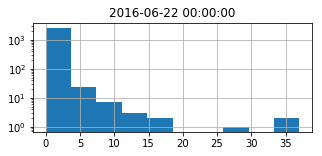

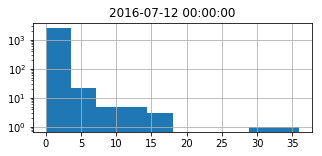

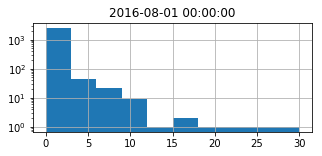

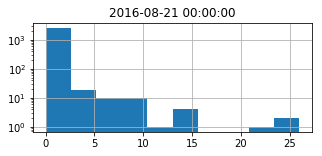

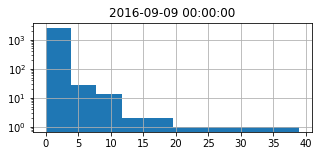

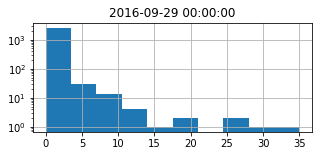

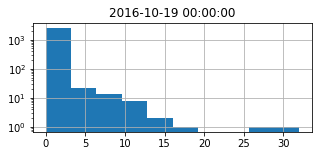

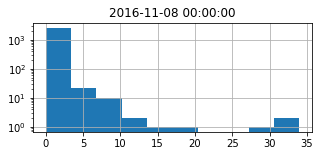

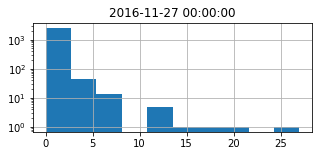

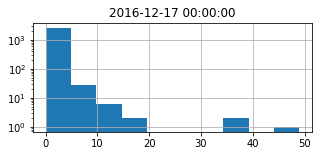

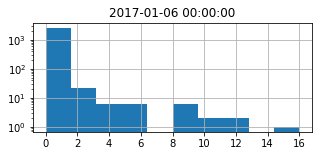

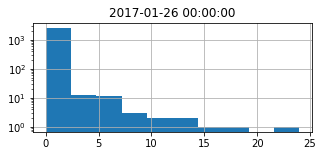

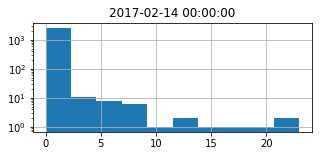

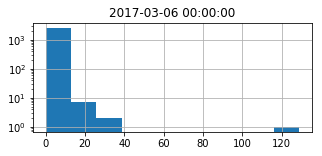

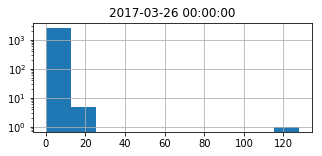

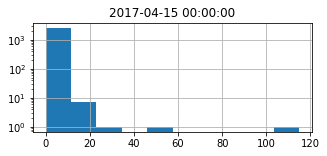

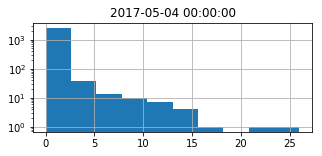

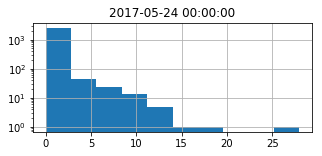

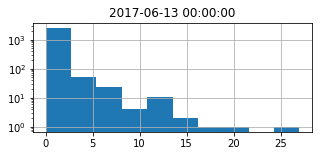

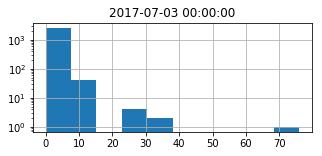

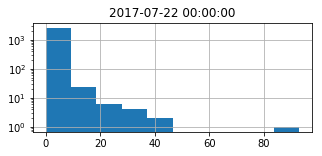

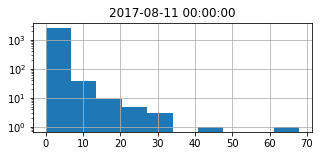

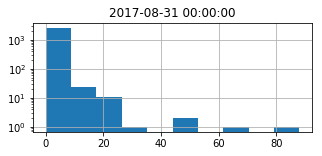

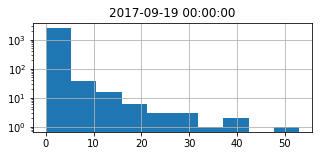

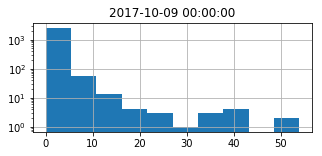

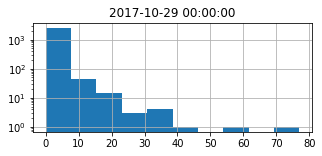

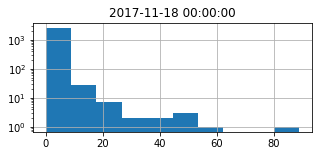

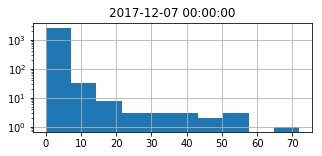

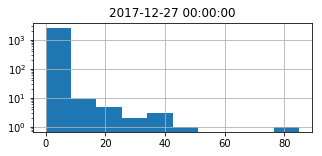

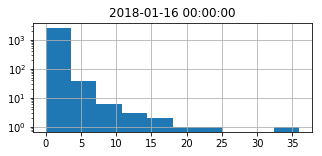

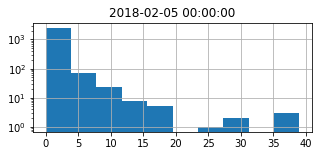

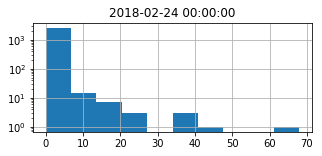

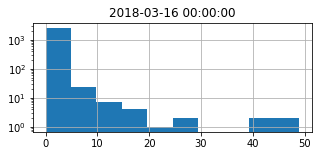

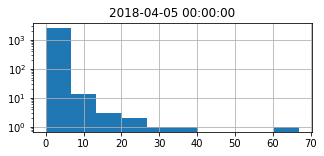

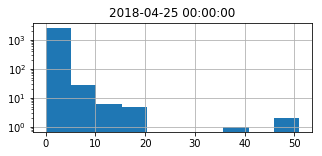

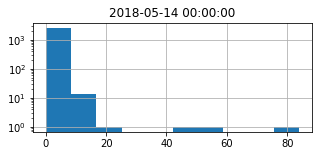

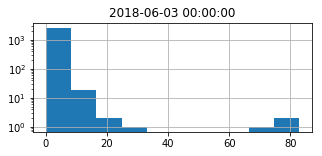

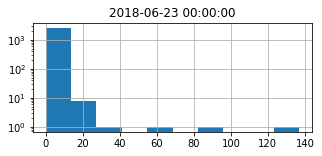

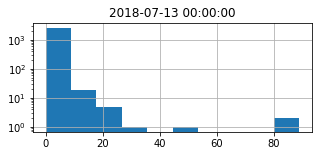

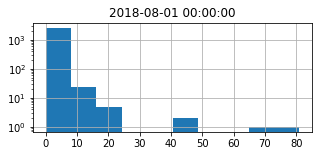

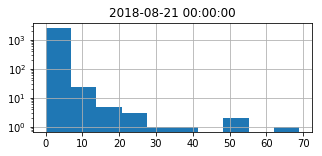

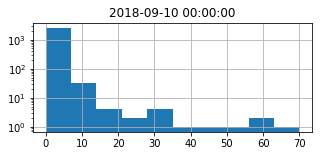

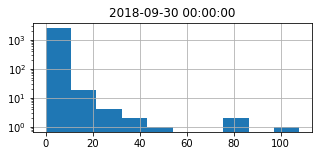

C:\Users\DavideMariani\Anaconda3\envs\mlflow\lib\site-packages\matplotlib\ticker.py:2198: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  "Data has no positive values, and therefore cannot be "


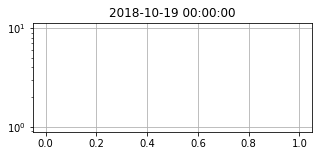

C:\Users\DavideMariani\Anaconda3\envs\mlflow\lib\site-packages\matplotlib\ticker.py:2198: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  "Data has no positive values, and therefore cannot be "


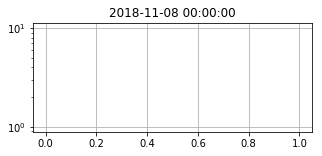

C:\Users\DavideMariani\Anaconda3\envs\mlflow\lib\site-packages\matplotlib\ticker.py:2198: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  "Data has no positive values, and therefore cannot be "


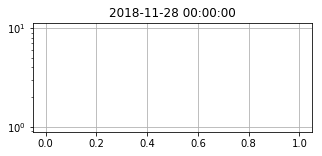

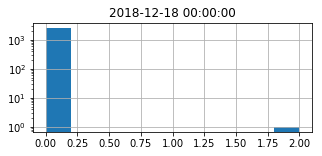

In [55]:
for date in dates_linspace:
    plt.figure(figsize=(5,2))
    df_degree_clean[df_degree_clean.date==date]['degree'].hist(bins=10, log=True)
    plt.title(date)
    plt.show()

In [56]:
print("Again non-stationarity in network flows distribution; saturated time-windows with power-law like distribution")

Again non-stationarity in network flows distribution; saturated time-windows with power-law like distribution


In [57]:
 df_degree_gr = df_degree.groupby('date').agg([('max',max),
                              ('average',np.mean),
                              ('std',np.std),
                              ('count',lambda value: sum(value>0))])

In [58]:
df_degree_gr = df_degree_gr.reset_index()

In [59]:
list_degree_gr = []
for row in df_degree_gr.itertuples():
    list_degree_gr.append({'date':row[1],
                          'max':row[2],
                          'average':row[3],
                          'std':row[4],
                          'count':row[5]})
df_degree_gr_new = pd.DataFrame.from_records(list_degree_gr)
df_degree_gr_new = df_degree_gr_new[['date','max','average','std','count']]

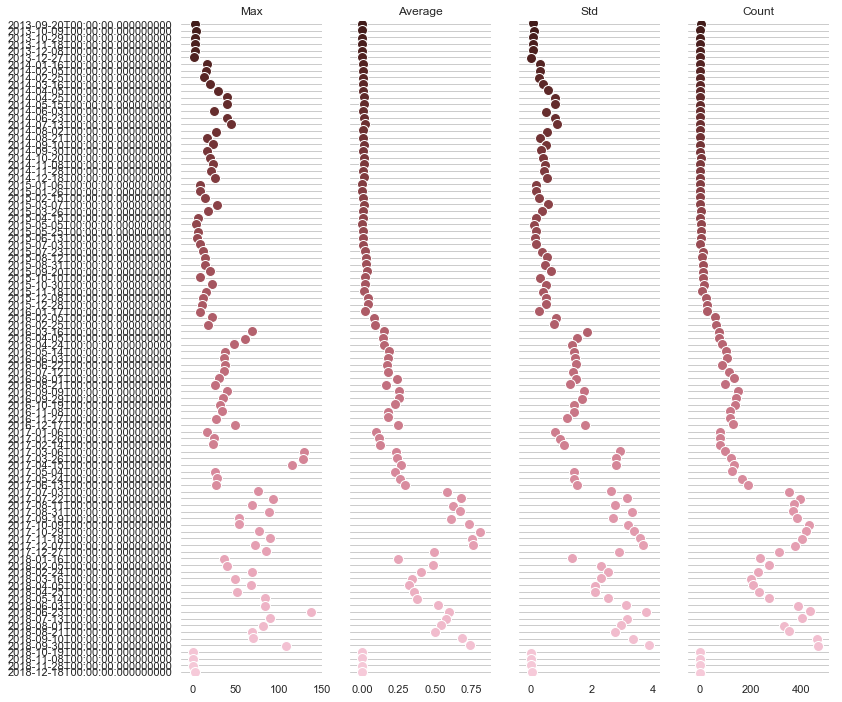

In [60]:
sns.set(style="whitegrid")

# Make the PairGrid
g = sns.PairGrid(df_degree_gr_new,
                 x_vars=df_degree_gr_new.columns[1:], y_vars=["date"],
                 height=10, aspect=.25)

# Draw a dot plot using the stripplot function
g.map(sns.stripplot, size=10, orient="h",
      palette="ch:s=1,r=-.1,h=1_r", linewidth=1, edgecolor="w")

# Use the same x axis limits on all columns and add better labels
g.set(xlabel="", ylabel="")

# Use semantically meaningful titles for the columns
titles = ["Max",
         "Average",
         "Std",
         'Count']

for ax, title in zip(g.axes.flat, titles):

    # Set a different title for each axes
    ax.set(title=title)

    # Make the grid horizontal instead of vertical
    ax.xaxis.grid(False)
    ax.yaxis.grid(True)

sns.despine(left=True, bottom=True)